## Assess the novelty of the Li Dataset

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from MINOV.novelty import compute_MI_novelty
from MINOV.density import compute_MI_density, get_MI_profile
from utils import *

from pymatgen.core import Structure

import textalloc as ta
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from style import mpl_style

import warnings
warnings.filterwarnings("ignore")

Custom matplotlib styles have been applied.


/Users/andrewf/miniconda3/envs/MINOV/lib/python3.10/site-packages/ElMD/ElMD.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Load formulas and structures from dataset folder.

In [2]:
MAT_DS = "perovskite_dataset"
DS_PATH = os.path.join("data", MAT_DS)
# get all cif files in folder
files = [file for file in os.listdir(DS_PATH) if ".cif" in file]

structures = []
formulas = []
space_group_numbers = []
unit_cell_vols = []
for filename in files:
    structure = Structure.from_file(os.path.join(DS_PATH, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))
    space_group_numbers.append(structure.get_space_group_info()[1]) 
    unit_cell_vols.append(structure.volume)


data = pd.DataFrame({"formula": formulas, "structure": structures, "spacegroup": space_group_numbers, "volume": unit_cell_vols, "filename": files})
data['anion_class'] = data['formula'].apply(lambda x: re.sub(r'[0-9]', '', x.split(" ")[-1]))

In [3]:
MAT_DS = 'MP_Li_dataset'
DS_PATH = os.path.join("data", MAT_DS)
# get all cif files in folder
files = [file for file in os.listdir(DS_PATH) if ".cif" in file]

structures = []
formulas = []
files = os.listdir(DS_PATH)
files = [file for file in files if ".cif" in file]
for filename in files:
    structure = Structure.from_file(os.path.join(DS_PATH, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))

mp = np.ones((len(structures)))

data = pd.DataFrame({'formula': formulas, 'structure': structures, 'filename': files, 'mp': mp})

MAT_DS = 'GNOME_Li_dataset'
DS_PATH = os.path.join("data", MAT_DS)

structures = []
formulas = []
files = os.listdir(DS_PATH)
files = [file for file in files if ".cif" in file]
for filename in files:
    structure = Structure.from_file(os.path.join(DS_PATH, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))

mp = np.zeros((len(structures)))

# append to the data
data = pd.concat([data, pd.DataFrame({'formula': formulas, 'structure': structures, 'filename': files, 'mp': mp})], ignore_index=True)

### Compute the distance matrices for the dataset, if necessary.

In [4]:
data, mi_data = compute_MI_novelty(
    data = data,
    compute_metrics = None,
    precomputed_metrics={
        "lostop": "Li_lostop_dm.npy",
        "elmd": "Li_elmd_dm.npy",
        },
    data_dir="precomputed",
    data_prefix="Li",
)

MI cutoff for lostop: 2.4367534301084146
MI cutoff for elmd: 18.680198894472362


### Compute the densities of GNOME materials against the MP corpus.

Here we deliberately filter the GNOME indices in order to assess each of them against the MP database separately.

In [5]:
lostop_dm = np.load("precomputed/Li_lostop_dm.npy")
elmd_dm = np.load("precomputed/Li_elmd_dm.npy")

mi_data = {}

GNOME_idx = data[data['mp'] == 0].index
MP_idx = data[data['mp'] == 1].index

for dm, name in zip([lostop_dm, elmd_dm], ["lostop", "elmd"]):

    # only select rows and columns associated with MP materials
    filtered_dm = dm.copy()
    filtered_dm = filtered_dm[MP_idx][:, MP_idx]

    cutoff, mi_profile = get_MI_profile(filtered_dm, n_thresholds=200)
    mi_data[name] = [cutoff, mi_profile]

    print(f"MI cutoff for {name}: {cutoff}")

    dens, weight_function = compute_MI_density(filtered_dm, cutoff, mi_profile)

    # now iteratively add the GNOME materials to the density matrix and append their density
    for G_idx in GNOME_idx:
        filtered_dm = dm.copy()
        # drop every other GNOME material except the one we are interested in from row and column
        filtered_dm = np.delete(filtered_dm, GNOME_idx[GNOME_idx != G_idx], axis=0)
        filtered_dm = np.delete(filtered_dm, GNOME_idx[GNOME_idx != G_idx], axis=1)

        dens_G, weight_function_G = compute_MI_density(filtered_dm, cutoff, mi_profile)
        dens = np.concatenate((dens, np.array([dens_G[-1]])))

    data[f'{name}_density'] = dens

MI cutoff for lostop: 2.4367534301084146
MI cutoff for elmd: 18.255648919597988


### Plot material densities along chemical and structural axes.

Note that the publication figure was adjusted post-hoc for visual clarity due to positioning issues with the `textalloc` library.

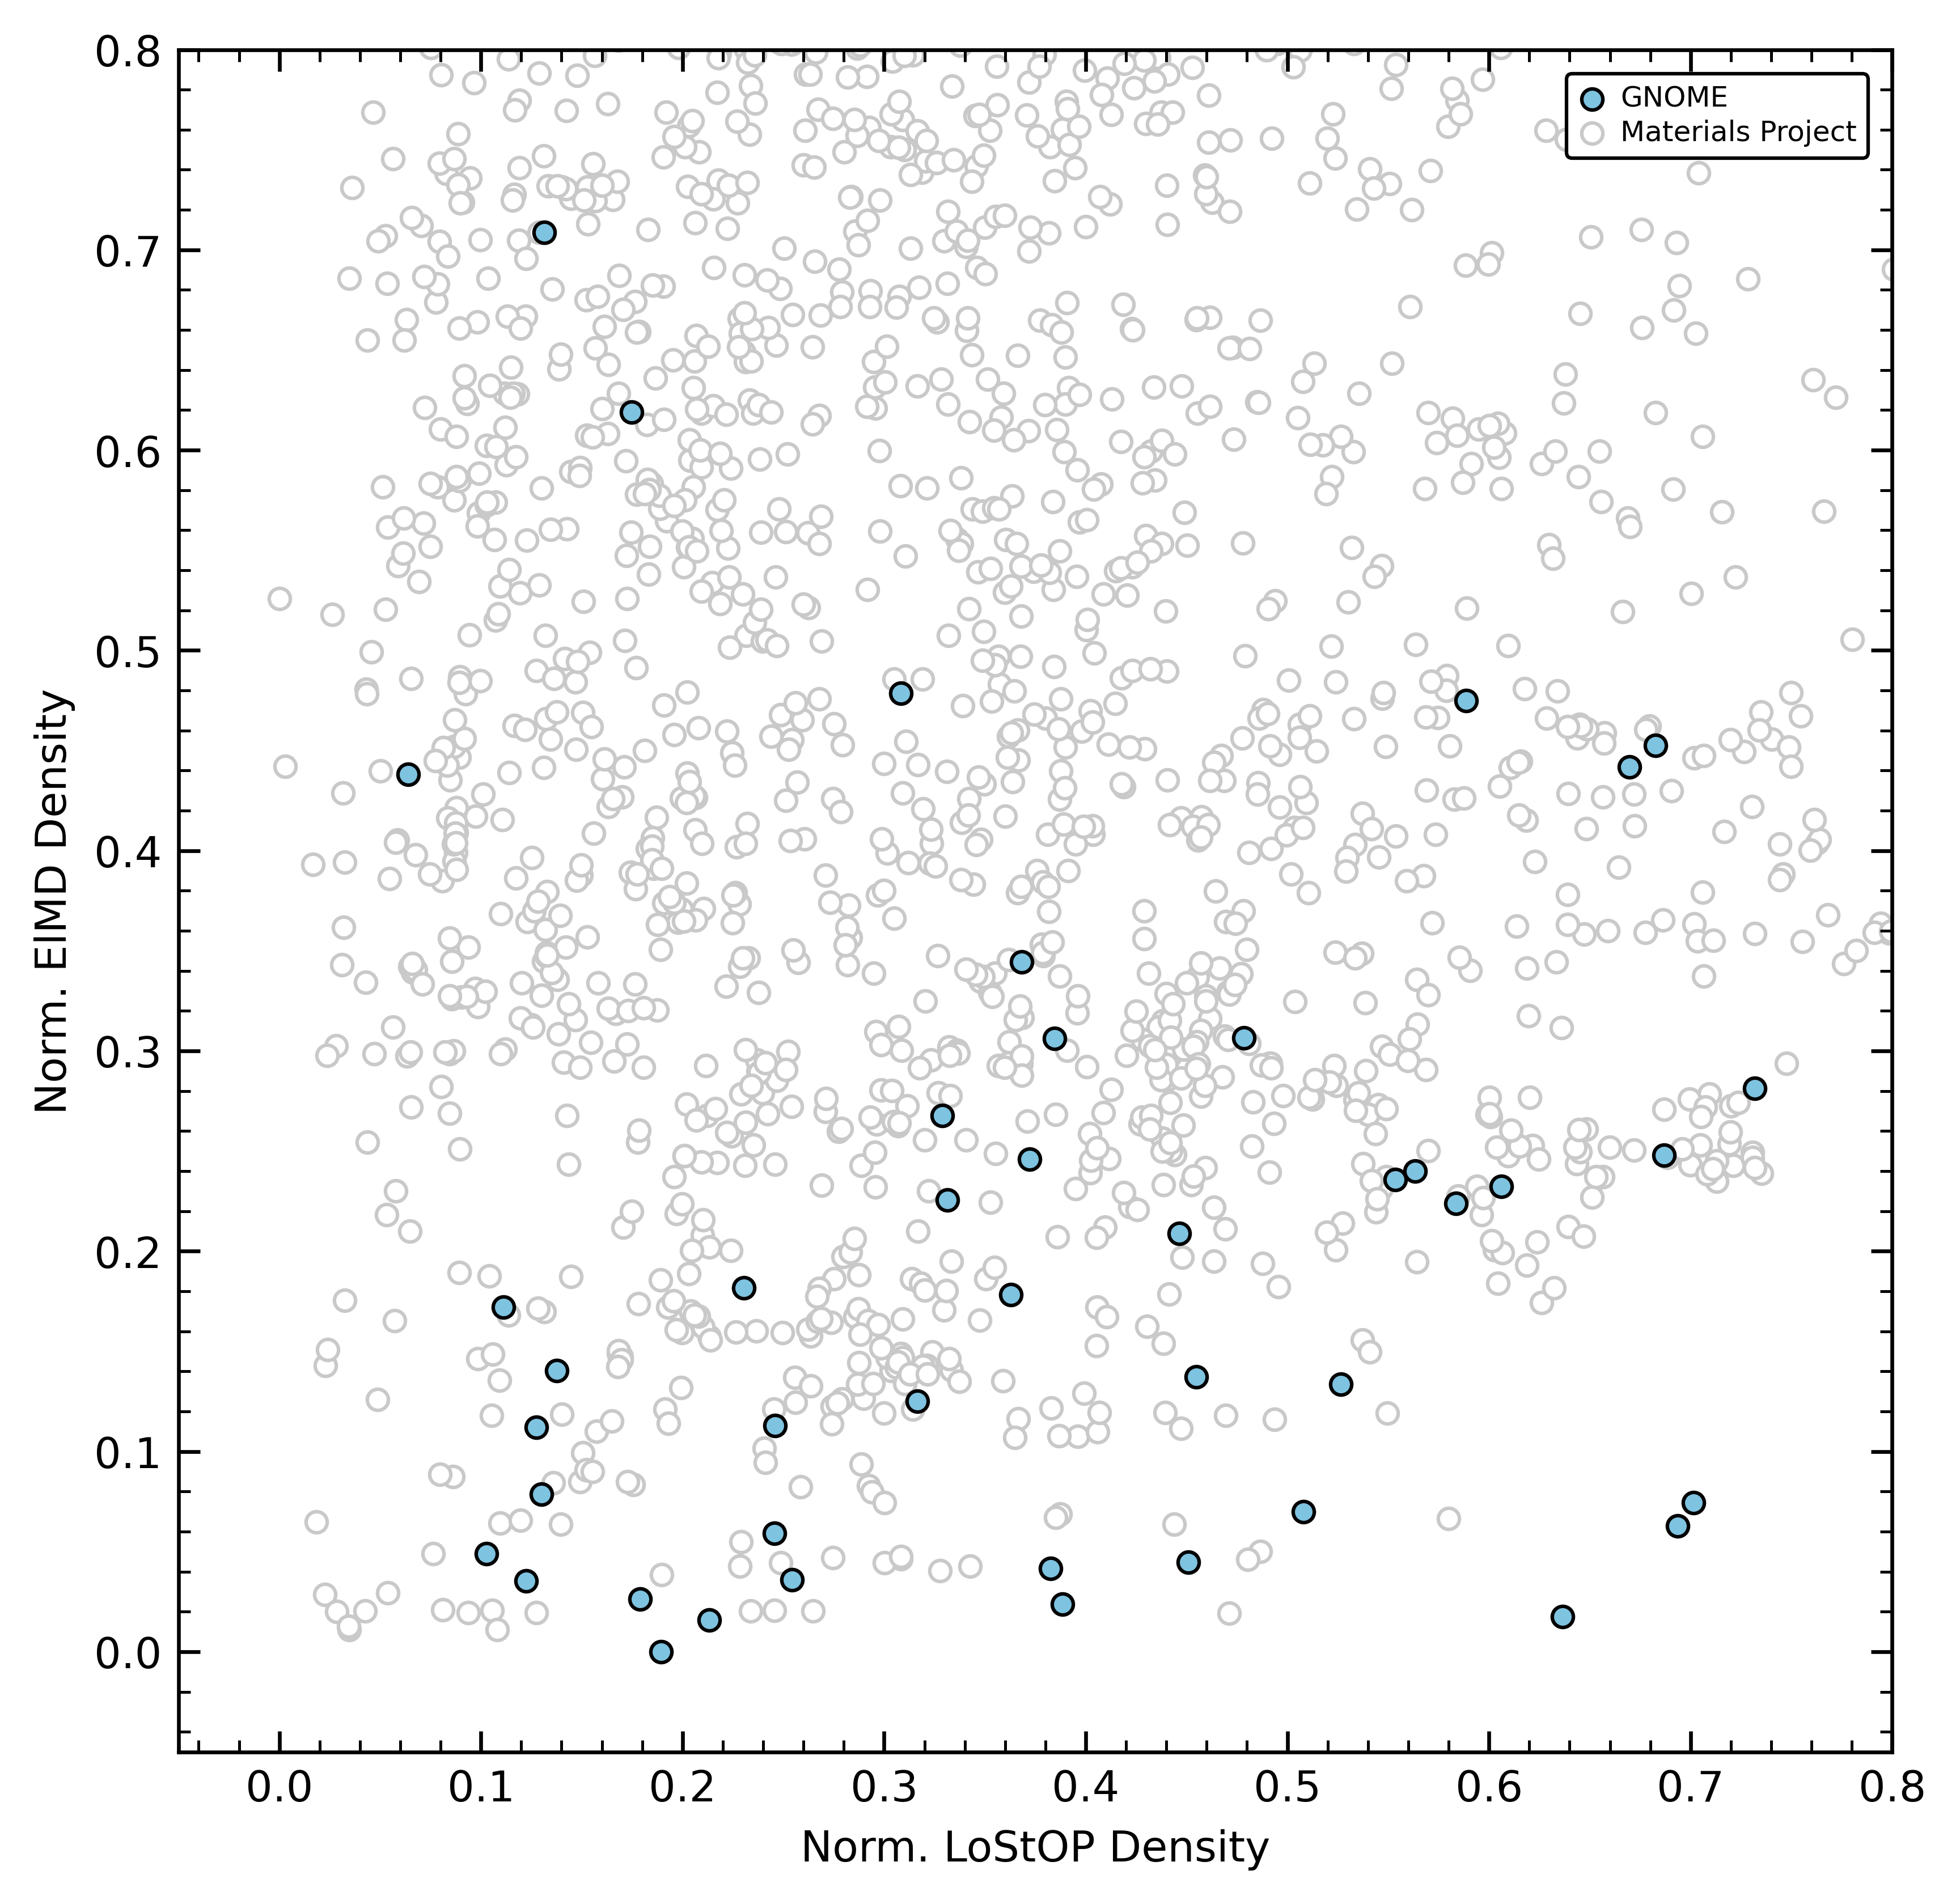

In [6]:
scaled_df = data.copy()

# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

G_idx = np.where(data['mp'] == 0)[0]

fig, ax = plt.subplots(figsize=(6.5, 6.5), dpi=600)

# Plot all points
for i in range(len(data)):
    ax.scatter(
        scaled_df['lostop_density'].iloc[i],
        scaled_df['elmd_density'].iloc[i],
        fc='#7EC3E0' if i in G_idx else 'w',
        # fc='#E0877E' if i in G_idx else 'w',
        ec='k' if i in G_idx else '#c9c9c9',
        s=20,
        zorder=10 if i in G_idx else 1,
        lw=0.75
    )

ax.scatter([],[], fc='#7EC3E0', ec='k', lw=0.75, s=20, label='GNOME')
ax.scatter([],[], fc='w', ec='#c9c9c9', lw=0.75, s=20, label='Materials Project')

legend = ax.legend(loc='upper right', fontsize=6, frameon=True, framealpha=1.0, labelspacing=0.25)
legend.get_frame().set_linewidth(0.75)

ax.set_xlim(None, 0.8)
ax.set_ylim(None, 0.8)

ax.set_xlabel("Norm. LoStOP Density")
ax.set_ylabel("Norm. ElMD Density")

plt.show()

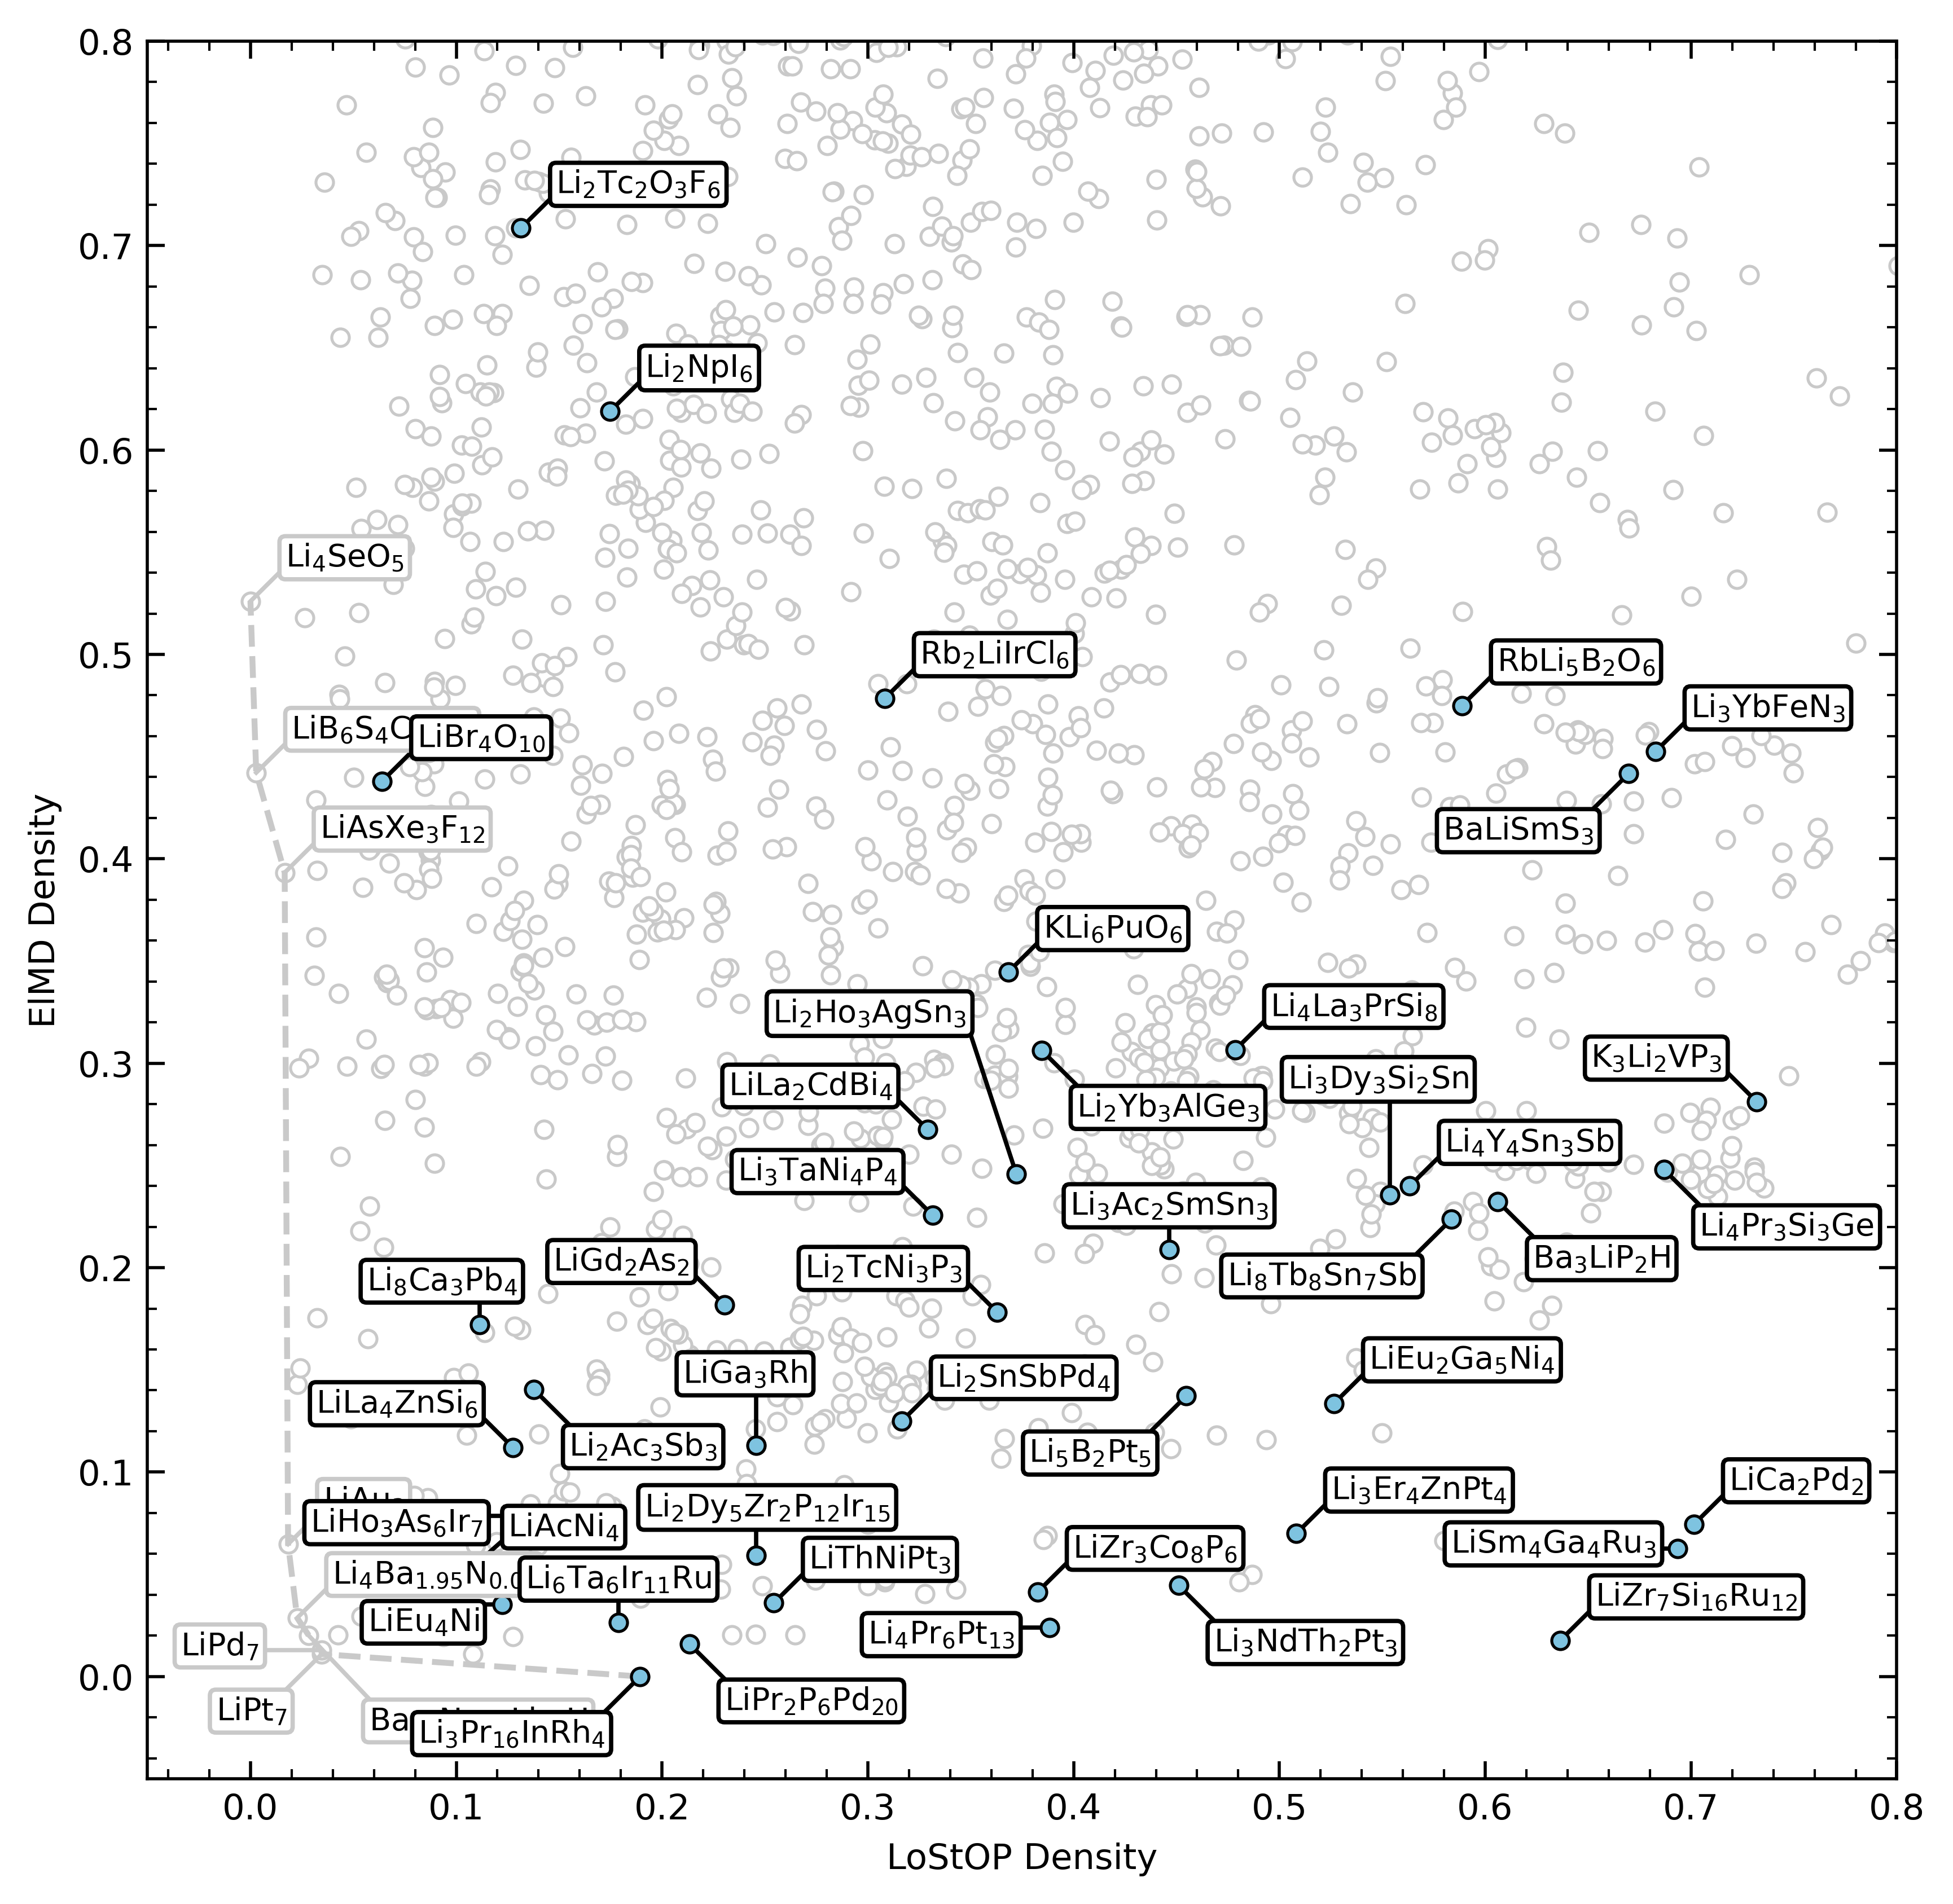

In [7]:
scaled_df = scaled_df.copy()
# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

fig, ax = plt.subplots(figsize=(8, 8), dpi=500)

p_idx = is_pareto_efficient(scaled_df[['lostop_density', 'elmd_density']].values, return_mask=False)

G_idx = np.where(scaled_df['mp'] == 0)[0]

# Plot all points
for i in range(len(scaled_df)):
    ax.scatter(
        scaled_df['lostop_density'].iloc[i],
        scaled_df['elmd_density'].iloc[i],
        fc='#7EC3E0' if i in G_idx else 'w',
        # fc='#E0877E' if i in G_idx else 'w',
        ec='k' if i in G_idx else '#c9c9c9',
        s=20,
        zorder=10 if i in G_idx else 1,
        lw=0.75
    )


ax.set_xlim(None, 0.8)
ax.set_ylim(None, 0.8)

pareto_x = scaled_df['lostop_density'].loc[p_idx]
pareto_y = scaled_df['elmd_density'].loc[p_idx]
pareto_x, pareto_y = zip(*sorted(zip(pareto_x, pareto_y), key=lambda pair: pair[1]))
ax.plot(pareto_x, pareto_y, color='#c9c9c9', lw=1.5, ls='--', marker='None')

# if any p_idx is in G_idx, remove it
p_idx = np.array([i for i in p_idx if i not in G_idx])

labels = [reduce_single_formula(formula) for formula in scaled_df['formula'].values]
pareto_labels = [labels[i] for i in p_idx]

pareto_labels[1] = "Li$_{4}$Ba$_{1.95}$N$_{0.05}$"
pareto_labels[6] = "Ba$_{38}$Na$_{58}$Li$_{26}$H"

ta.allocate(ax,
            x=scaled_df['lostop_density'].loc[p_idx],
            y=scaled_df['elmd_density'].loc[p_idx],
            text_list=pareto_labels,
            x_scatter=scaled_df['lostop_density'].loc[p_idx].values,
            y_scatter=scaled_df['elmd_density'].loc[p_idx].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            margin=0.012,
            textsize=8,
            nbr_candidates=1000,
            linecolor='#C9C9C9',
            linewidth=1.1,
            min_distance=0.02,
            # max_distance=0.03,
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="#C9C9C9", pad=0.19, lw=1.1),
            zorder=25,
            )

GNOME_labels = [labels[i] for i in G_idx]

ta.allocate(ax,
            x=scaled_df['lostop_density'].loc[G_idx],
            y=scaled_df['elmd_density'].loc[G_idx],
            text_list=GNOME_labels,
            x_scatter=scaled_df['lostop_density'].loc[G_idx].values,
            y_scatter=scaled_df['elmd_density'].loc[G_idx].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            margin=0.012,
            textsize=8,
            nbr_candidates=1000,
            linecolor='k',
            linewidth=1.1,
            min_distance=0.02,
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="k", pad=0.19, lw=1.1),
            zorder=25,
            )

# Set labels
plt.rcParams['svg.fonttype'] = 'none'
ax.set_xlabel("LoStOP Density")
ax.set_ylabel("ElMD Density")
plt.show()